# Basic Prototype 2

Builds on Basic Prototype 1, adds yolov8 pose detection. Landmarks will be saved in a datastructure which then will be visualised and probably exported as a JSON so that it can be trained on Google Colab. This prototype focuses on testing if an AI model can be trained to interpolate and output the correct landmarks to continue the video sequence after being trained on the sequences of the videos.

Pose detection wise, Openpose is better since it has more landmarks and also tracks the foot, it is also based on C++ so it's quicker, but I cannot get openpose to work yet, so I will implement using YOLOv8 for now just to test the AI model structure. 

Mediapipe is also a possibility but it can only detect 1 person at a time and is much slower. 

Still the broadcast on OBS has to be started manually first.

In [1]:
# imports

import pytchat
import cv2
import glob
import ultralytics
import torch
import time
import numpy as np
from collections import defaultdict
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import mdn
import random
import tensorflow as tf

files = glob.glob('G:/UAL_Thesis/raw_videos/*')
print(files)


['G:/UAL_Thesis/raw_videos\\idle_bob_1.MOV', 'G:/UAL_Thesis/raw_videos\\idle_bob_2.MOV', 'G:/UAL_Thesis/raw_videos\\jump_out_in.MOV', 'G:/UAL_Thesis/raw_videos\\step_f_b.MOV', 'G:/UAL_Thesis/raw_videos\\step_l.MOV', 'G:/UAL_Thesis/raw_videos\\step_l_r.MOV', 'G:/UAL_Thesis/raw_videos\\step_r.MOV', 'G:/UAL_Thesis/raw_videos\\step_r_l.MOV']


In [2]:
from PIL import Image

def draw_skeleton(result):
    """draw frame from YOLOv8 results"""
    for r in result:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    return np.array(im)[..., ::-1]  # Convert PIL Image back to BGR numpy array

In [3]:
# test YOLOv8 pose recognition with 1 file first

"""Check hardware and load model"""


# Check if GPU is available otherwise use CPU for torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# If GPU is available set model to use half-precision floating-point numbers
if torch.cuda.is_available():
    model.half().to(device)

# load model
video_path = files[1]
model = ultralytics.YOLO('yolov8n-pose.pt')

# predict

cap = cv2.VideoCapture(video_path)
start_time = time.time()

# resize cv2 window

# Get the original video dimensions
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the desired width and calculate the height to maintain the aspect ratio
desired_width = 540  # You can change this value
aspect_ratio = height / width
desired_height = int(desired_width * aspect_ratio)

# Get video, pose analyse and display pose detection frame by frame
pose_results = defaultdict(int)
i=0

while(cap.isOpened() and time.time()):
    ret, frame = cap.read()
    if ret == True:
        result = model.predict(frame)
        pose_results[i] = result
        i = i+1
        annotated_frame = draw_skeleton(result)
        # Resize the frame while maintaining the aspect ratio
        resized_frame = cv2.resize(annotated_frame, (desired_width, desired_height))
        cv2.imshow('Frame', resized_frame)
        
        # Press Q on keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
cv2.destroyAllWindows 





0: 640x384 1 person, 59.0ms
Speed: 2.0ms preprocess, 59.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 46.5ms
Speed: 1.0ms preprocess, 46.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 44.5ms
Speed: 2.0ms preprocess, 44.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 42.5ms
Speed: 2.0ms preprocess, 42.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 42.5ms
Speed: 1.0ms preprocess, 42.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 41.0ms
Speed: 1.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 46.0ms
Speed: 1.0ms preprocess, 46.0ms inference, 1.0ms postprocess per image at shape (1, 3, 64

<function destroyAllWindows>

In [4]:
def define_keypoints():
    return {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16
}

In [5]:
from collections import defaultdict

# LSTM - adapted from AI for media 
# https://git.arts.ac.uk/tbroad/AI-4-Media-22-23/blob/main/Week%205.1%20LSTM%20for%20forecasting%20and%20movement%20generation/Generating_Movement_Sequences_with_LSTM.ipynb

# define keypoints
keypoints = {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16
}


# convert tensor of xy coordinate per frame into a pandas time series
keypoints_dict_master = defaultdict(dict)

for frame, results in pose_results.items():
    for idx, person in enumerate(results):
        # Check if person has the attribute 'keypoints' and it has the attribute 'xy'
        if hasattr(person, 'keypoints') and hasattr(person.keypoints, 'xy'):
            tensor_values = person.keypoints.xy
            
            # Convert tensor to dictionary format
            keypoint_coordinates = {key: tensor_values[0][value] for key, value in keypoints.items() if value < len(tensor_values[0])}
            
            # Use idx as a unique identifier for each person
            keypoints_dict_master[frame][idx] = keypoint_coordinates


# LSTM

In [6]:
# convert to pandas of each keypoint coordinate for each frame

# Flatten the dictionary
rows = []
for frame, persons in keypoints_dict_master.items():
    for person, keypoints in persons.items():
        row = {'frame': frame, 'person': person}
        for keypoint, coordinates in keypoints.items():
            row[f'{keypoint}_x'] = coordinates[0]
            row[f'{keypoint}_y'] = coordinates[1]
        rows.append(row)

# Convert to DataFrame
df = pd.DataFrame(rows)

df

,frame,person,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,0,tensor(548.0113),tensor(253.8890),tensor(581.6307),tensor(223.7902),tensor(507.8804),tensor(227.8574),tensor(628.7161),tensor(260.6825),...,tensor(434.2933),tensor(925.0344),tensor(577.6923),tensor(1317.9408),tensor(438.9280),tensor(1312.3743),tensor(548.4213),tensor(1634.8854),tensor(450.7043),tensor(1627.9724)
1,1,0,tensor(546.6755),tensor(253.1892),tensor(580.1018),tensor(222.3493),tensor(506.0098),tensor(226.8007),tensor(627.4545),tensor(258.5030),...,tensor(433.1544),tensor(927.4625),tensor(577.1816),tensor(1318.5016),tensor(438.3349),tensor(1311.7001),tensor(549.1968),tensor(1634.1621),tensor(450.1331),tensor(1625.4786)
2,2,0,tensor(546.6104),tensor(252.9438),tensor(579.6425),tensor(222.1322),tensor(505.6010),tensor(226.8907),tensor(626.6183),tensor(259.1334),...,tensor(433.5181),tensor(926.8917),tensor(576.4340),tensor(1318.7595),tensor(438.6196),tensor(1311.5155),tensor(550.3526),tensor(1634.6078),tensor(451.2119),tensor(1624.9901)
3,3,0,tensor(544.0967),tensor(252.5411),tensor(578.2271),tensor(221.6877),tensor(503.2304),tensor(226.3312),tensor(627.1232),tensor(259.2605),...,tensor(433.1701),tensor(926.5743),tensor(576.8007),tensor(1317.3296),tensor(437.6906),tensor(1310.5129),tensor(550.4597),tensor(1633.7355),tensor(452.6882),tensor(1624.2433)
4,4,0,tensor(541.8898),tensor(252.8846),tensor(576.3556),tensor(222.8937),tensor(501.8326),tensor(226.7325),tensor(625.4022),tensor(261.7588),...,tensor(433.0803),tensor(925.6930),tensor(576.6702),tensor(1317.1176),tensor(437.1123),tensor(1309.4464),tensor(549.8908),tensor(1632.8727),tensor(453.4856),tensor(1622.9381)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,259,0,tensor(577.7915),tensor(227.9224),tensor(609.9910),tensor(195.5344),tensor(539.4560),tensor(202.7635),tensor(664.3465),tensor(226.5148),...,tensor(495.3130),tensor(912.9177),tensor(647.8160),tensor(1296.1514),tensor(507.9951),tensor(1288.1588),tensor(632.4402),tensor(1611.2257),tensor(527.8400),tensor(1597.7319)
260,260,0,tensor(576.8605),tensor(226.1658),tensor(608.8916),tensor(193.7439),tensor(538.2430),tensor(201.3604),tensor(663.2470),tensor(225.0101),...,tensor(494.5897),tensor(913.1466),tensor(648.5621),tensor(1296.0864),tensor(508.2196),tensor(1288.7867),tensor(633.2721),tensor(1612.1653),tensor(528.1397),tensor(1598.9480)
261,261,0,tensor(578.3124),tensor(223.8032),tensor(610.0950),tensor(191.2101),tensor(538.9871),tensor(199.1104),tensor(663.7280),tensor(222.7904),...,tensor(494.8543),tensor(913.6138),tensor(649.2602),tensor(1295.1915),tensor(508.4270),tensor(1287.7676),tensor(633.3417),tensor(1610.9923),tensor(526.9686),tensor(1597.7045)
262,262,0,tensor(579.3981),tensor(224.5157),tensor(610.7469),tensor(191.7832),tensor(539.7184),tensor(199.9108),tensor(663.5896),tensor(222.7725),...,tensor(496.1612),tensor(913.8593),tensor(649.9182),tensor(1295.8854),tensor(509.9422),tensor(1288.4877),tensor(633.6883),tensor(1612.3271),tensor(527.1351),tensor(1598.2003)


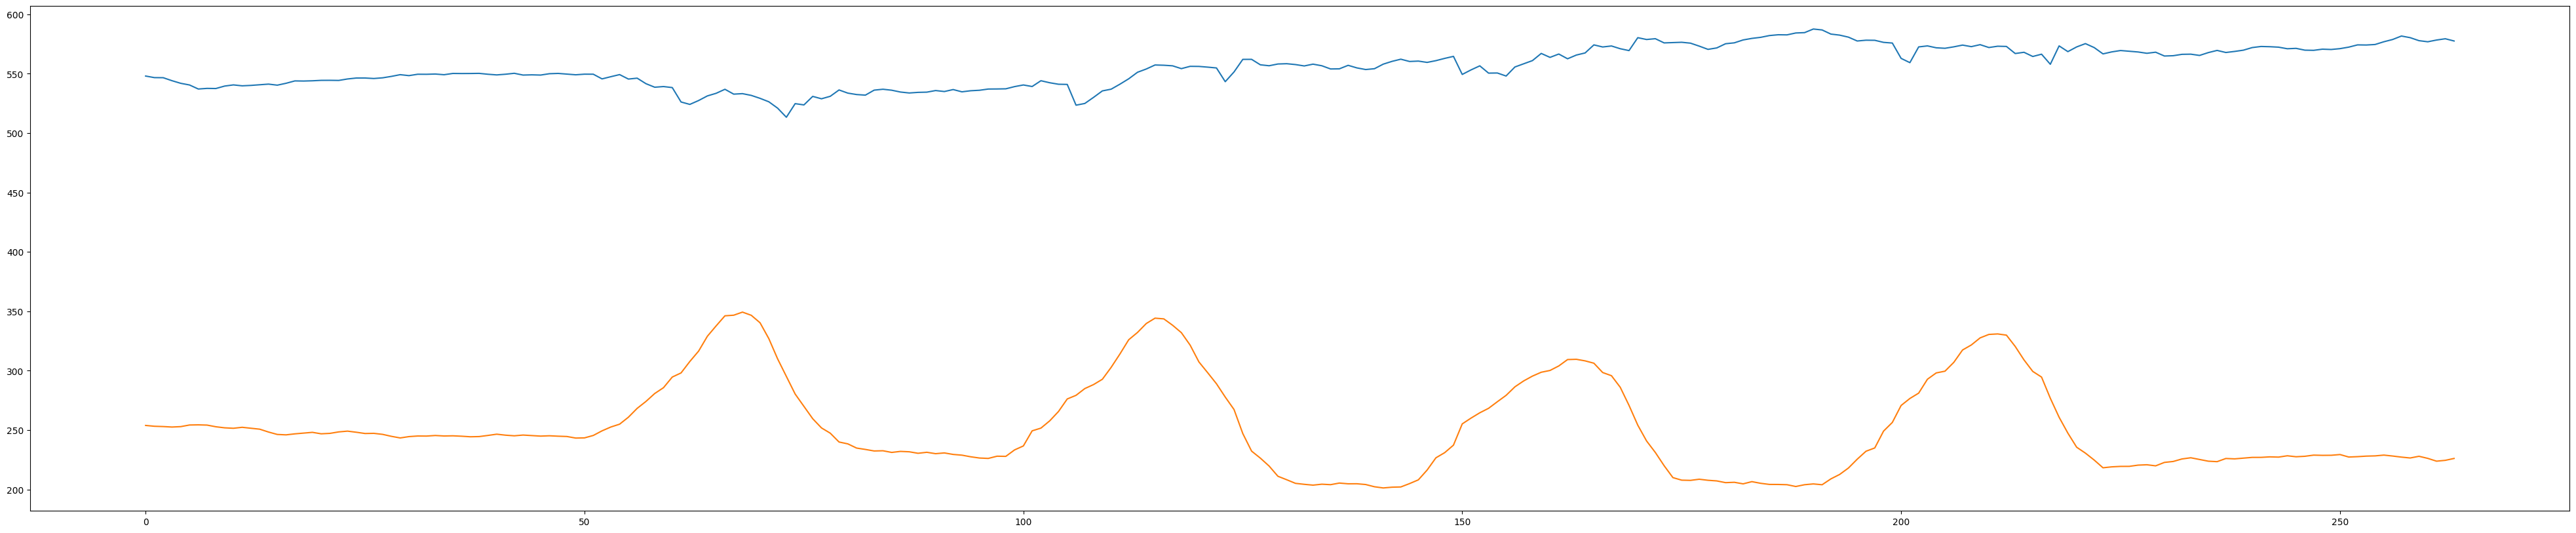

In [7]:
import matplotlib.pyplot as plt

# sample visualise change in nose_x, nose_y position

# Plotting the change of coordinates values for 1 body joint, e.g. the nose
plt.figure(figsize=(50, 10))

plt.plot(df['nose_x']) #blue line
plt.plot(df['nose_y']) #orange line

plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
        
        # output is list of list of num_steps number of rows (e.g. num_setps =  50 will be 50 first rows, all columns)
    return xs

def seq_to_singleton_format(examples):
    # Takes the sliced sequences and separates each sequence into input (all elements except the last one) and output (just the last element).
    # up until last sequence used as primer
    
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)  

# Turning our dataframe structure into an array, excluding the first 2 columns of person and frame
seq = np.array(df.iloc[:len(df),2:])

# Normalising our data with min max
sc = MinMaxScaler()
seq = sc.fit_transform(seq)

# Defining and using our window size to create our inputs X and outputs y
SEQ_LEN = 50
slices = slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_singleton_format(slices)

X = np.array(X)
y = np.array(y)

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

Number of training examples:
X: (212, 50, 34)
y: (212, 34)


In [9]:
# train test split

from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((142, 50, 34), (142, 34), (70, 50, 34), (70, 34))

In [10]:
# Training Hyperparameters:
BATCH_SIZE = 64
HIDDEN_UNITS = 256 #256
EPOCHS =  100
OUTPUT_DIMENSION = 34 # the number of coordinates x2 for x and y
NUMBER_MIXTURES = 10

# Sequential model
model = Sequential()

# Add two LSTM layers, make sure the input shape of the first one is (?, fit into any sequence length?, 26)
model.add(LSTM(HIDDEN_UNITS, batch_input_shape=(None,None,OUTPUT_DIMENSION), return_sequences=True))
model.add(LSTM(HIDDEN_UNITS))

# Here's the MDN layer, need to specify the output dimension (26) and number of mixtures (10)
model.add(mdn.MDN(OUTPUT_DIMENSION, NUMBER_MIXTURES))

# If you did not want to use an MDN, you could instead add a Dense Layer
# model.add(Dense(26))

# Now we compile the MDN RNN - need to use a special loss function with the right number of dimensions and mixtures.
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMENSION,NUMBER_MIXTURES), optimizer='adam')

# This compiler would be used if we only used a Dense layer instead of the MDN
# model.compile(optimizer='adam', loss='mean_squared_error')

# Let's see what we have:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         297984    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 mdn (MDN)                   (None, 690)               177330    
                                                                 
Total params: 1,000,626
Trainable params: 1,000,626
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Fit the model
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/100
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
4/4 [==============================] - 4s 20ms/step - loss: 33.0273
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 13.1581
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: -2.2125
Epoch 4/100
4/4 [==============================] - 0s 18ms/step - loss: -8.7307
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: -16.7243
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: -21.9706
Epoch 7/100
4/4 [==============================] - 0s 18ms/step - loss: -24.4043
Epoch 8/100
4/4 [==============================] - 0s 17ms/step - loss: -25.8876
Epoch 9/100
4/4 [==============================] - 0s 16ms/step - loss: -28.0418
Epoch 10/100
4/4 [==============================] - 0s 18ms/step - loss: -30.3093
Epoch 11/100
4/4 [==============================] - 0s 18ms/step - lo

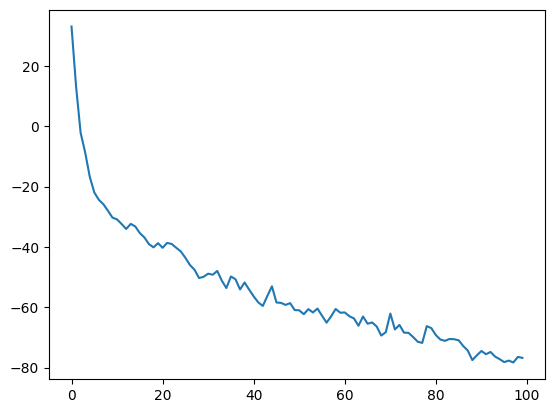

In [12]:
# Plot our loss
plt.figure()
plt.plot(history.history['loss'])
plt.show()

In [13]:
# Version 1
# Priming as if saying "get inspiration from" these many inputs, it gives it from context 
# Imagine that it has been trained on approx 1h of dancing
# This is tell it to use inspiration from a specific part
def prime_model(input):
    pred = model.predict(tf.expand_dims(input, axis=0))
    
# Predicting for a sequence of frames, p is the starting point, length the number of frames
def predict_sequence(p, length, temp=2.5, sigma_temp=0.1):
    result = [p.reshape(1,OUTPUT_DIMENSION)]
    for i in range(length):
        pred = model.predict(p.reshape(1,1,OUTPUT_DIMENSION))
        p = mdn.sample_from_output(pred[0], OUTPUT_DIMENSION, NUMBER_MIXTURES, temp=temp, sigma_temp=sigma_temp)
        result.append(p)
    return tf.concat(result, axis=0)

model.reset_states()
# how many should be primed?
n=3
prime_model(X_test[0][:n]) # prime model with the first n points
pred = predict_sequence(X_test[0][n], 500) #start from point n and predict for 50 more
pred.shape

1/1 [==============================] - 0s 14ms/step


TensorShape([501, 34])

In [14]:
# Reversing the normalisation we did before the training
pred_f = sc.inverse_transform(pred)

# Storing predictions in a dataframe
df_f = pd.DataFrame(pred_f)

pred_f.shape

(501, 34)

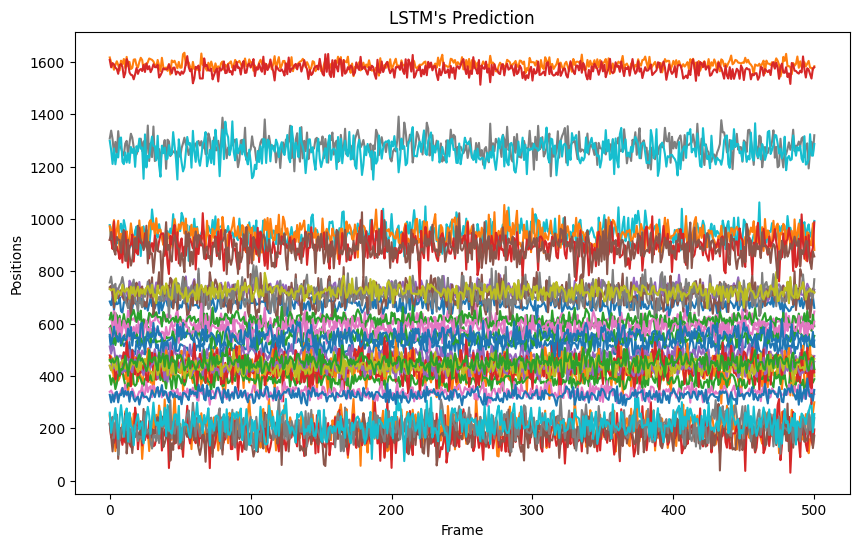

In [15]:
# Plotting the predicted/generated coordinates
plt.figure(figsize=(10, 6))
plt.plot(pred_f, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Frame')
plt.ylabel('Positions')
plt.show()

In [16]:
pd.DataFrame(pred_f).head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,549.701294,245.414062,584.686768,215.988922,511.937256,217.885529,631.975220,252.615143,457.079712,259.310944,...,438.144012,920.247803,582.143372,1307.084839,439.520874,1298.524414,556.904419,1616.847046,461.378357,1607.490601
1,493.698909,199.590690,592.786561,164.448282,484.575440,168.343949,626.108980,218.134589,461.992246,182.419492,...,421.589656,950.404544,552.762019,1337.441873,421.129339,1262.292729,521.030703,1597.106646,451.031242,1578.976377
2,505.446678,231.205386,524.364964,224.593944,516.575224,111.205516,586.856260,243.578868,412.683808,222.307774,...,466.887947,918.371654,548.216977,1304.745960,436.047807,1209.864888,547.510168,1590.768823,463.921235,1595.319166
3,543.591456,206.427028,562.255985,144.008565,506.969359,173.087303,656.466272,163.067328,441.518662,235.693443,...,427.956868,879.498057,551.824563,1247.809311,467.147356,1269.111999,588.102812,1569.840039,450.408058,1590.407948
4,523.700183,112.432793,517.788123,208.283476,465.619936,218.883656,597.239413,220.290358,446.428759,276.912953,...,453.738314,863.219464,640.549149,1294.260294,433.466116,1208.628927,556.103861,1588.044619,455.401309,1577.539071


In [17]:
pred_df  = pd.DataFrame(pred_f)
pred_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,...,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,515.652581,202.545173,550.414084,172.461034,479.026601,175.376865,607.489871,207.439934,433.453891,218.184665,...,432.558540,888.901877,579.347496,1275.278340,435.788093,1259.341269,549.404901,1590.064735,452.541794,1570.590122
std,22.858040,44.832569,21.122880,45.631049,21.417147,41.683819,19.405980,40.335638,21.301969,41.060850,...,19.602474,42.865137,24.160153,37.441296,21.879551,42.633701,26.590940,15.727630,22.771597,21.021046
min,439.424388,56.331998,485.213559,29.858516,413.925419,38.438872,555.811603,97.680270,354.074785,74.201869,...,377.324425,748.805218,488.067246,1162.718806,366.343094,1150.064724,466.375880,1543.985019,380.520728,1512.691824
25%,499.892403,173.552764,535.328906,141.415205,466.014865,148.037448,593.642308,179.063396,418.589893,191.109364,...,418.535640,861.361075,563.399433,1251.521389,421.428461,1227.849262,531.730754,1579.427552,437.752552,1555.123978
50%,515.308940,202.192431,549.916850,170.016669,479.171218,177.882633,606.889724,207.030413,434.119569,217.413247,...,431.242885,889.673258,579.811115,1273.443365,434.424739,1259.532684,548.791522,1590.051338,452.983209,1571.338828
75%,532.739523,232.371269,565.332112,202.356522,494.038994,200.672927,619.229154,236.151403,447.327380,245.590541,...,447.855592,916.946553,595.309091,1298.278561,450.045768,1291.574038,566.490171,1601.279216,468.896899,1583.867301
max,582.617927,328.270010,609.154432,311.446229,542.885627,294.035893,678.036832,316.068698,505.437940,332.645866,...,492.827398,1025.434076,676.140156,1390.843423,496.407222,1372.670901,617.925942,1635.013431,516.867422,1630.346254


In [18]:
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# prediction results dataframe
pred_df = pd.DataFrame(pred_f)
scaled_df = pred_df/2 # Scale data


# Define the pairs of keypoints for the skeleton
skeleton_pairs = [
    ("nose", "left_eye"),
    ("nose", "right_eye"),
    ("left_eye", "left_ear"),
    ("right_eye", "right_ear"),
    ("left_shoulder", "right_shoulder"),
    ("left_shoulder", "left_elbow"),
    ("right_shoulder", "right_elbow"),
    ("left_elbow", "left_wrist"),
    ("right_elbow", "right_wrist"),
    ("left_hip", "right_hip"),
    ("left_hip", "left_knee"),
    ("right_hip", "right_knee"),
    ("left_knee", "left_ankle"),
    ("right_knee", "right_ankle"),
    
]

keypoints = define_keypoints()


try:
    
    window_y,window_x = 500,1500

    # Set up the VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # or use 'MP4V' for .mp4 videos
    out = cv2.VideoWriter(f"video_documentation/idle_bob_1_{EPOCHS}_epochs_256_hidden_proto2_ai4medialstm.mp4", fourcc, 20.0, (window_y, window_x))
    # Iterate over each row in the dataframe
    for _, row in scaled_df.iterrows():
        image = np.zeros((window_x, window_y, 3), dtype=np.uint8)
        
        # Draw the keypoints and labels
        for key, idx in keypoints.items():
            x = int(row[idx * 2])
            y = int(row[idx * 2 + 1])
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
            cv2.putText(image, key, (x + 5, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        
        # Draw the skeleton
        for pair in skeleton_pairs:
            pt1_idx = keypoints[pair[0]] * 2
            pt2_idx = keypoints[pair[1]] * 2
            pt1 = (int(row[pt1_idx]), int(row[pt1_idx + 1]))
            pt2 = (int(row[pt2_idx]), int(row[pt2_idx + 1]))
            cv2.line(image, pt1, pt2, (0, 255, 0), 2)
  
        cv2.imshow("Keypoints", image)
        out.write(image)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break


finally:
    out.release()
    cv2.destroyAllWindows()


In [19]:
pred_df 

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,549.701294,245.414062,584.686768,215.988922,511.937256,217.885529,631.975220,252.615143,457.079712,259.310944,...,438.144012,920.247803,582.143372,1307.084839,439.520874,1298.524414,556.904419,1616.847046,461.378357,1607.490601
1,493.698909,199.590690,592.786561,164.448282,484.575440,168.343949,626.108980,218.134589,461.992246,182.419492,...,421.589656,950.404544,552.762019,1337.441873,421.129339,1262.292729,521.030703,1597.106646,451.031242,1578.976377
2,505.446678,231.205386,524.364964,224.593944,516.575224,111.205516,586.856260,243.578868,412.683808,222.307774,...,466.887947,918.371654,548.216977,1304.745960,436.047807,1209.864888,547.510168,1590.768823,463.921235,1595.319166
3,543.591456,206.427028,562.255985,144.008565,506.969359,173.087303,656.466272,163.067328,441.518662,235.693443,...,427.956868,879.498057,551.824563,1247.809311,467.147356,1269.111999,588.102812,1569.840039,450.408058,1590.407948
4,523.700183,112.432793,517.788123,208.283476,465.619936,218.883656,597.239413,220.290358,446.428759,276.912953,...,453.738314,863.219464,640.549149,1294.260294,433.466116,1208.628927,556.103861,1588.044619,455.401309,1577.539071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,497.746400,104.495163,560.253390,176.937732,474.330735,227.832204,641.334730,267.617846,456.685540,262.178016,...,456.207825,865.802169,601.296431,1192.785926,433.872858,1228.690949,551.074508,1603.856663,419.762063,1569.930950
497,532.917108,158.014460,512.469362,203.751948,451.064944,200.191236,586.091933,192.470524,400.634036,284.762447,...,432.359947,837.043006,578.131571,1256.311500,443.929706,1323.564855,526.918839,1577.514736,450.066759,1552.751699
498,526.216557,160.444929,526.649398,151.984532,479.171218,216.762887,572.145926,251.288745,421.401371,299.662445,...,425.319355,808.531538,594.265477,1294.618259,475.815843,1242.342599,518.743018,1577.302451,469.907104,1536.333639
499,512.449625,257.176927,537.321670,132.652935,450.439974,123.961812,616.521761,192.562782,447.731836,184.137397,...,444.826724,874.874195,580.479169,1250.163827,457.093925,1241.370831,568.496533,1570.294997,467.094205,1574.748646


# GAN - Temporal GANs

# Transformers

In [20]:
# transformers taken from Aksan et al 2021
# https://github.com/eth-ait/motion-transformer
# body pose data deep inertial poser https://dip.is.tue.mpg.de/download.php

In [21]:
# https://docs.ultralytics.com/modes/predict/#keypoints

for person in result:
   print(person.keypoints.xy)

tensor([[[ 577.5127,  226.0952],
         [ 609.5530,  193.1802],
         [ 538.8023,  200.8163],
         [ 664.4314,  223.4404],
         [ 494.3451,  244.6249],
         [ 739.1966,  444.2262],
         [ 451.9687,  460.3725],
         [ 790.5558,  727.5428],
         [ 390.3636,  740.5133],
         [ 773.8361,  973.3709],
         [ 382.7873,  966.4279],
         [ 678.3329,  914.1348],
         [ 496.6207,  915.4054],
         [ 650.1769, 1297.2836],
         [ 509.3653, 1289.0243],
         [ 634.1794, 1611.8878],
         [ 527.6819, 1597.6074]]])


In [22]:
# GAN